# Class for solving the ising model for a square and triangular 2D lattice, with an optional magnetic field

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from scipy.optimize import curve_fit

In [2]:
class Solve:

    def __init__(self, gridsize, J ,  T, stopping_iter, field, triangular):
        
        #initialising relavent variables
        self.stopping_iter = stopping_iter
        self.iteration = 1
        self.B=field
        self.J = J
        self.T = T 
        self.triangular=triangular
        self.gridsize = gridsize
        self.points = self.gridsize**2

        #initialising grid
        self.current_grid = np.random.choice([-1.,1.], size=(gridsize,gridsize), replace=True)
        self.initial_grid = np.copy(self.current_grid)       

        #Defining fitness
        self.initial_fitness=np.copy(np.array(self.in_fitness(self.current_grid)))
        self.current_fitness=np.copy(np.array(self.initial_fitness))

        #initialising acceptance probabilitys for the square case
        self.prob4J, self.prob8J = np.exp( -abs( 4.*self.J )* (1/self.T)), np.exp( -abs( 8.*self.J ) * (1./self.T)) 
        
        #initialising states, energy, temp and magnetism lists for averages 
        self.states=[]
        self.states.append(np.copy(self.current_grid))
        
        self.mag_list=[]
        self.mag_list.append( np.copy(self.current_grid).sum() )
        
        self.en_list=[]
        self.en_list.append( self.energy(self.current_grid) )
        self.E_i=self.en_list[0]

    def in_fitness(self,grid):
        #Creating initial fitness grids to store data determining if each point will change spin or remain
        fitness_lattice=np.zeros_like(self.current_grid)
        
        if self.triangular==True:
            
            for i in range(0,self.gridsize):
                for j in range(0,self.gridsize):
                    fit = (2.)* self.J * grid[i,j] * (grid[(i+1)%(self.gridsize),j] + grid[(i-1)%(self.gridsize),j] + grid[i,(j+1)%(self.gridsize)] + grid[i,(j-1)%(self.gridsize)]) 
                    ext = (2.)*(self.J)*grid[i%(self.gridsize),j%(self.gridsize)]*(grid[(i-1)%(self.gridsize),(j+1)%(self.gridsize)]+grid[(i-1)%(self.gridsize),(j-1)%(self.gridsize)])
                    b = self.B * grid[i%(self.gridsize),j%(self.gridsize)]
                    fitness_lattice[i,j] = fit + b + ext
        else:
            
            for i in range(0,self.gridsize):
                for j in range(0,self.gridsize):
                    fit = (2.)*self.J*grid[i,j]*(grid[(i+1)%(self.gridsize),j] + grid[(i-1)%(self.gridsize),j] + grid[i,(j+1)%(self.gridsize)] + grid[i,(j-1)%(self.gridsize)])  #energy of one state being the sum of contributions from its neighbours
                    b = self.B * grid[i%(self.gridsize),j%(self.gridsize)]
                    fitness_lattice[i,j] = fit + b
        
        return fitness_lattice

    
    def fitness(self, grid , i, j ):
        #Conditions for both types of lattice
        if self.triangular==True:
            squ = (2.)*(self.J)*grid[i%(self.gridsize),j%(self.gridsize)]*(grid[(i+1)%(self.gridsize),j%(self.gridsize)] + grid[(i-1)%(self.gridsize),j%(self.gridsize)] + grid[i%(self.gridsize),(j+1)%(self.gridsize)] + grid[i%(self.gridsize),(j-1)%(self.gridsize)])
            ext = (2.)*(self.J)*grid[i%(self.gridsize),j%(self.gridsize)]*(grid[(i-1)%(self.gridsize),(j+1)%(self.gridsize)]+grid[(i-1)%(self.gridsize),(j-1)%(self.gridsize)])
            b = self.B * grid[i%(self.gridsize),j%(self.gridsize)]
            fit = squ+ext+b
            
        else:
            fit = (2.)*(self.J)*grid[i%(self.gridsize),j%(self.gridsize)]*(grid[(i+1)%(self.gridsize),j%(self.gridsize)] + grid[(i-1)%(self.gridsize),j%(self.gridsize)] + grid[i%(self.gridsize),(j+1)%(self.gridsize)] + grid[i%(self.gridsize),(j-1)%(self.gridsize)])
            b = self.B * grid[i%(self.gridsize),j%(self.gridsize)]
            fit = fit + b
            
        return fit
 

    def plot_grid(self,grid):
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        
        if self.triangular == False:
            #plotting square lattice
            ax.matshow(grid,cmap=cm.Set3,vmin=-1., vmax=1.) #-1=blue, 1=yellow
            ax.set_xticks([])
            ax.set_yticks([])

        else:
            #plotting triangular lattice
            points=np.array([[a-(b%2)*(0.5), b*np.sqrt(3)/2] for a in np.linspace(0,self.gridsize-1,self.gridsize) for b in np.linspace(0,self.gridsize-1,self.gridsize)])
            flatgrid=np.copy(grid).flatten()
            ax.scatter(points[:,0],points[:,1], marker='s', c=flatgrid, vmin=-1, vmax=1,cmap=cm.Set3)
            ax.set_xticks([])
            ax.set_yticks([])
            
        return fig, ax
    
    
    def accept( self, candidate, i, j ):
        '''sets the acceptance rules for a new candidate'''
        candidate_fitness = np.array(self.fitness( candidate, i, j ) )
        
        if candidate_fitness <= 0:
            self.current_grid [i,j] = (-1.)*(np.copy(candidate[i,j]))
            
        else:
            # accepting with probability e^(-b*dE) when fitness>0 
            r=np.random.random()
            # Conditions for non triangular, no magnetic field         
            if self.B==0 and self.triangular==False:
                if candidate_fitness == 4*self.J:
                    if r < self.prob4J:  
                        self.current_grid[i,j] = (-1.)*(candidate[i,j])                        
                else:
                    if r < self.prob8J:  
                        self.current_grid[i,j] = (-1.)*(candidate[i,j])  
            else:
                # Conditions for non triangular and magnetic field         
                if r < np.exp( -abs( candidate_fitness * (1/self.T))):  
                    self.current_grid[i,j] = (-1.)*(candidate[i,j])


    def isinginate(self):
        # Controls number of system updates
        for stop in range(0,self.stopping_iter-1):
            #sweep over the lattice    
            for j in range(0,self.gridsize):
                for i in range(0,self.gridsize):
                    #update fitness 
                    self.accept(self.current_grid ,i ,j )

                    if self.triangular == False:
                        self.current_fitness[i , j] = self.fitness( self.current_grid , i, j )
                        self.current_fitness[i , (j+1)%(self.gridsize)]=self.fitness( self.current_grid , i, j+1 )
                        self.current_fitness[i , (j-1)%(self.gridsize)]=self.fitness( self.current_grid , i, j-1 )
                        self.current_fitness[(i+1)%(self.gridsize) , j]=self.fitness( self.current_grid , i+1, j )
                        self.current_fitness[(i-1)%(self.gridsize) , j]=self.fitness( self.current_grid , i-1, j )
                        
                    else:
                        self.current_fitness[i , j] = self.fitness( self.current_grid , i, j )
                        self.current_fitness[i , (j+1)%(self.gridsize)]=self.fitness( self.current_grid , i, j+1 )
                        self.current_fitness[i , (j-1)%(self.gridsize)]=self.fitness( self.current_grid , i, j-1 )
                        self.current_fitness[(i+1)%(self.gridsize) , j]=self.fitness( self.current_grid , i+1, j )
                        self.current_fitness[(i-1)%(self.gridsize) , j]=self.fitness( self.current_grid , i-1, j )
                        self.current_fitness[(i-1)%(self.gridsize) , (j-1)%(self.gridsize)]=self.fitness( self.current_grid , i-1, j-1 )
                        self.current_fitness[(i-1)%(self.gridsize) , (j+1)%(self.gridsize)]=self.fitness( self.current_grid , i-1, j+1 )         
            #collect data every sweep
            self.mag_list.append( np.copy(self.current_grid).sum())
            self.en_list.append( self.energy( np.copy(self.current_grid) ) )
            self.states.append( np.copy(self.current_grid) )

    
    def energy(self, grid):
        #gererate energy data
        en = 0
        if self.triangular==True:
            for i in range(self.gridsize):
                for j in range(self.gridsize):
                    a = grid[i,j]
                    b = grid[(i+1)%self.gridsize, j] + grid[i,(j+1)%self.gridsize] + grid[(i-1)%self.gridsize, j] + grid[i,(j-1)%self.gridsize]
                    ex = grid[(i-1)%self.gridsize, (j-1)%(self.gridsize)]+grid[(i-1)%self.gridsize, (j+1)%(self.gridsize)]
                    en += ( - self.J * a * (b+ex) )
                    
        else:
            for i in range(self.gridsize):
                for j in range(self.gridsize):
                    a = grid[i,j]
                    b = grid[(i+1)%self.gridsize, j] + grid[i,(j+1)%self.gridsize] + grid[(i-1)%self.gridsize, j] + grid[i,(j-1)%self.gridsize]
                    en += ( - self.J * a * b)
        return en/2.

    def print_info(self):
        print('\ntemp=',self.T,'\niteration=',self.iteration, '\nprobability of accepting flip if del(E) = 4j, 8J =$',self.prob4J, self.prob8J,'\nNumber of sites =',self.points,'\nField =',self.B)



# Plot of magnetism against states at T=1. to see how many states to warm up
------------

I have used J=1 throughout this investigation, unless stated otherwise. Also a $7\times 7$ grid was used to take thermodynamic averages.

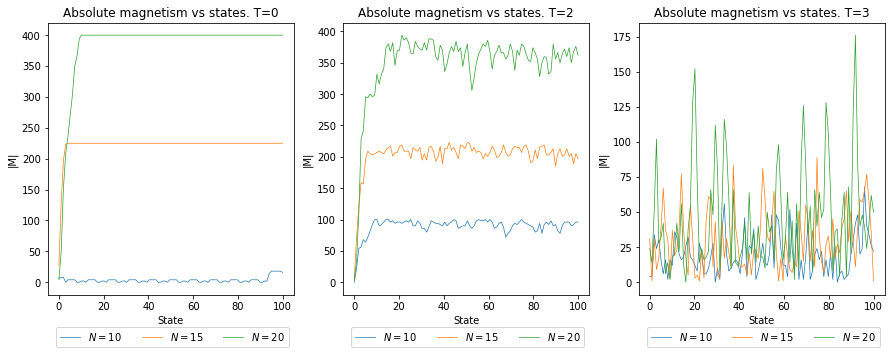

In [5]:
si=100
x=np.linspace(0,si,si)
gs=[10,15,20]
Ts=[0.5,2.,3.5]

fig1 = plt.figure(figsize=(15,5))

for i in range(0,3):
    solve1=Solve(gridsize=gs[0],  J=1.,  T=Ts[i], stopping_iter=si, field=0, triangular=False ) 
    solve2=Solve(gridsize=gs[1],  J=1.,  T=Ts[i], stopping_iter=si, field=0, triangular=False ) 
    solve3=Solve(gridsize=gs[2],  J=1.,  T=Ts[i], stopping_iter=si, field=0, triangular=False ) 

    solve1.isinginate()
    solve2.isinginate()
    solve3.isinginate()

    ax = fig1.add_subplot(1,3,i+1)
    ax.plot(x, np.abs(solve1.mag_list),linewidth = 0.7,label = '$N=%d$'%(gs[0]))
    ax.plot(x, np.abs(solve2.mag_list),linewidth = 0.7,label = '$N=%d$'%(gs[1]))
    ax.plot(x, np.abs(solve3.mag_list),linewidth = 0.7,label = '$N=%d$'%(gs[2]))
    ax.set_title('Absolute magnetism vs states. T=%d'%(Ts[i]))
    ax.legend(bbox_to_anchor=(1., -.1), ncol = 4)

    ax.set_xlabel('State')
    ax.set_ylabel('|M|')

plt.show()


# Visulising convergence of square lattices 
-------------

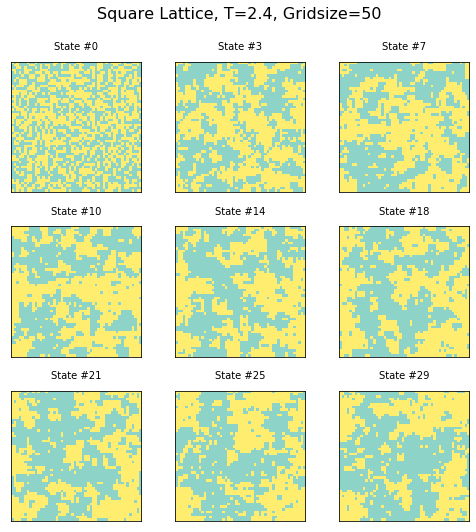

In [105]:
T=2.4
si2=30
gs=50
solveD=Solve(gridsize=gs,  J=1.,  T=T, stopping_iter=si2,field=0, triangular=False) 
solveD.isinginate()
statesD=solveD.states
fig2 = plt.figure(figsize=(7,7))
fig2.suptitle('Square Lattice, T=%s, Gridsize=%d'%(T,gs), fontsize=16, y=1.05)


for i,state in enumerate( np.linspace(0,si2-1,9, dtype=int) ):
    axa = fig2.add_subplot(3,3,i+1)
    axa.matshow(solveD.states[state],vmin=-1, vmax=1, cmap=cm.Set3) #-1=blue, 1=yellow
    axa.set_xticks([])
    axa.set_yticks([])
    axa.set_title('State #%d'%(state),fontsize=10)
    
plt.tight_layout()
plt.show()

# Visulising convergence of triangular lattices
------------

###### A $52 \times 52 $ grid has been used to display the triangular lattice, as it is the most convinent size.

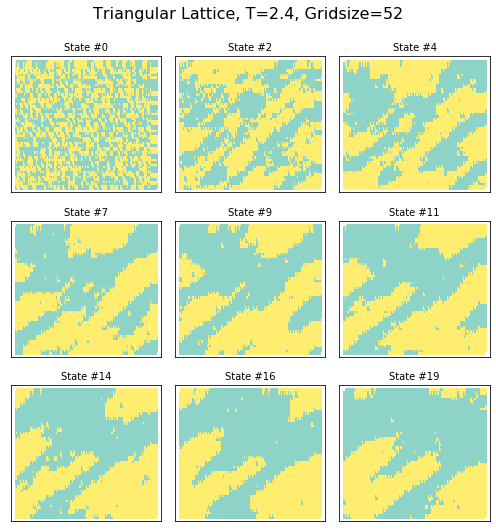

In [108]:
T=2.4
si2=20
gs=52
solveT=Solve(gridsize=gs,  J=1.,  T=T, stopping_iter=si2,field=0, triangular=True) 
solveT.isinginate()
states=solveT.states
points=np.array([[a+(b%2)*(0.5), b*np.sqrt(3)/2] for a in np.linspace(0,gs-1,gs) for b in np.linspace(0,gs-1,gs)])

fig3 = plt.figure(figsize=(7,7))
fig3.suptitle('Triangular Lattice, T=%s, Gridsize=%d'%(T,gs), fontsize=16, y=1.05)


for i,state in enumerate( np.linspace(0,si2-1,9, dtype=int) ):
    ax = fig3.add_subplot(3,3,i+1)
    
    flatgrid=states[state].flatten()
    ax.scatter(points[:,0],points[:,1], marker='s', c=flatgrid, vmin=-1, vmax=1,cmap=cm.Set3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('State #%d'%(state),fontsize=10)
    
plt.tight_layout()
plt.show()

-----------------
# Averages over temperature range, Square lattice

------------------


In [6]:
t0, tf, tempsteps = 0.1, 7., 300
testruns, countruns = 200, 300
gridsize=7

In [7]:
temp_list=np.linspace(t0,tf,tempsteps)
aven=[]
avmag=[]
stden=[]
stdma=[]

for i, temp in enumerate(temp_list):
    solve=Solve(gridsize,  J=1. ,  T=temp, stopping_iter=testruns+countruns,field = 0,triangular=False) 
    solve.isinginate()
    avmag.append(np.mean(solve.mag_list[-countruns:]))
    stdma.append(np.std(solve.mag_list[-countruns:]))
    aven.append(np.mean(solve.en_list[-countruns:]))
    stden.append(np.std(solve.en_list[-countruns:]))
    
avmag=np.array(avmag)/(gridsize**2)
aven=np.array(aven)/(gridsize**2)

## Defining $C_v,\chi$


In [8]:
C = ((np.array(stden))**2)/(np.array(temp_list)**2) #heat cap
X = ((np.array(stdma))**2)/np.array(temp_list) #mag sus

## Curve fit

In [65]:
#stretched exponential
def f1(x,a,b,c,d):  
    model = np.exp(-b*(x**(-c))) + d 
    return model

#tanh exponential
def f2(x,a,b,c,d):  
    model = a*np.tanh(-b*x+c)+ d
    return model

bestvals1, co = curve_fit(f1, temp_list, np.abs(avmag))
fit1 = f1(temp_list,*bestvals1)

bestvals2, co1 = curve_fit(f2, temp_list, aven)
fit2 = f2(temp_list,*bestvals2)


/Users/macuser/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Ploting

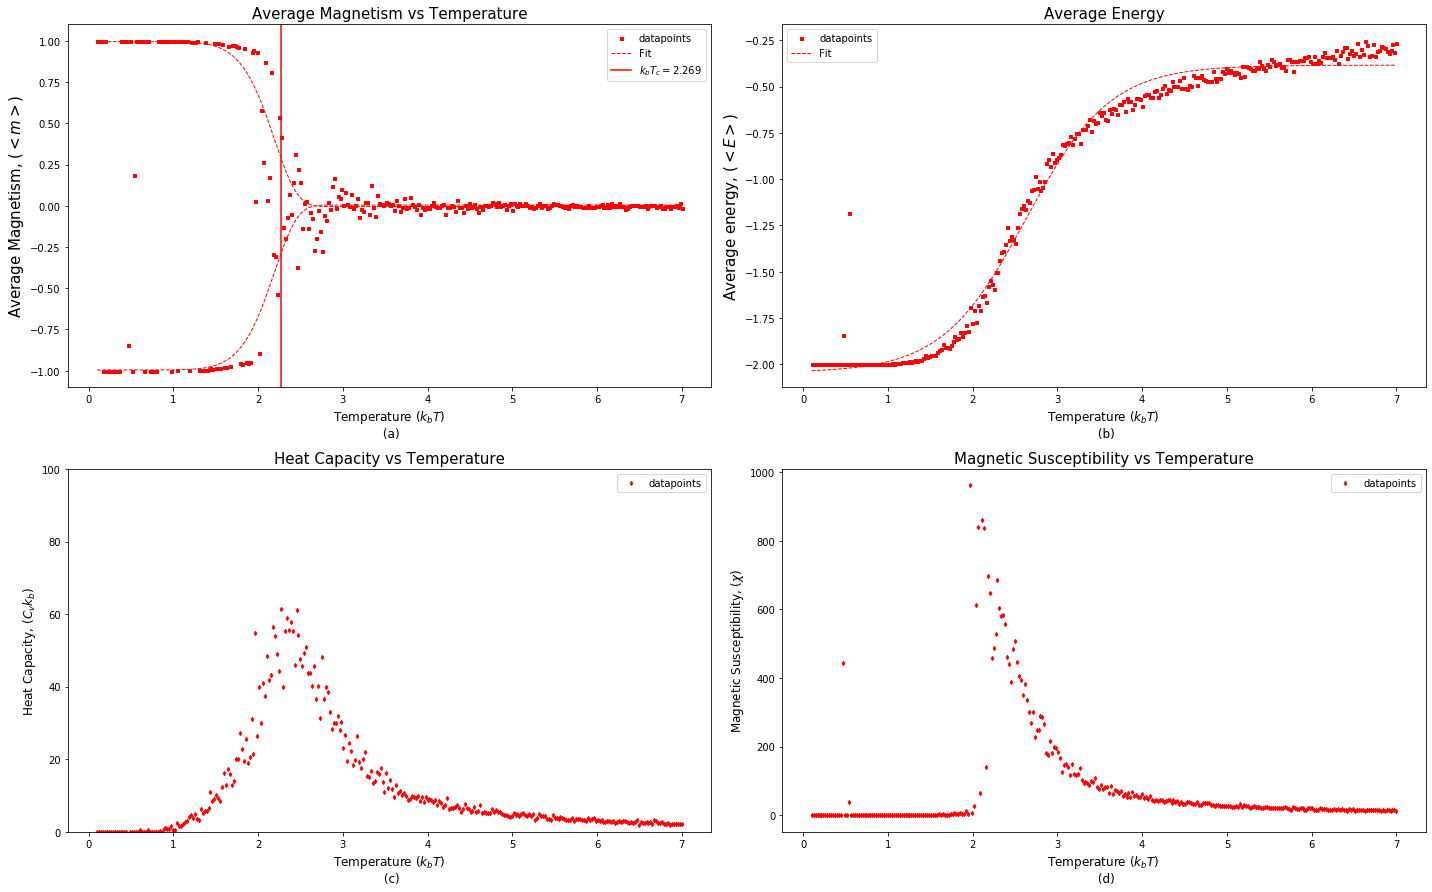

In [67]:
fig = plt.figure(figsize=(20,12.5))
ax1 = fig.add_subplot(221)

ax1.plot(temp_list, avmag, 'rs',markersize =3.0, label='datapoints')
ax1.plot(temp_list, fit1-0.02,'r--',linewidth=1.0, label='Fit')
ax1.plot(temp_list, -fit1+0.02,'r--',linewidth=1.0)


ax1.axvline(x=2.269, color='r',label='$k_bT_c=2.269$')
ax1.set_xlabel('Temperature ($k_b T$)\n (a)',fontsize=12)
ax1.set_ylabel('Average Magnetism, ($< m >$)',fontsize=15)
ax1.set_title('Average Magnetism vs Temperature',fontsize=15)
ax1.set_ylim(-1.1,1.1)
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.plot(temp_list, (aven), 'rs',markersize =3.0,label='datapoints')
ax2.set_xlabel('Temperature ($k_b T$) \n (b)',fontsize=12)
ax2.set_ylabel('Average energy, ($< E >$)',fontsize=15)
ax2.plot(temp_list, fit2, 'r--',linewidth=1.0, label='Fit')
ax2.set_title('Average Energy',fontsize=15)
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.plot(temp_list, C, 'rd',markersize =3.0,label='datapoints')
ax3.set_xlabel('Temperature ($k_b T$) \n (c)',fontsize=12)
ax3.set_ylabel('Heat Capacity, ($C_vk_b$)',fontsize=12)
ax3.set_title('Heat Capacity vs Temperature',fontsize=15)
ax3.set_ylim([0,100])
ax3.legend()


ax4 = fig.add_subplot(224)
ax4.plot(temp_list, X, 'rd',markersize =3.0,label='datapoints')
ax4.set_xlabel('Temperature ($k_b T$) \n (d)',fontsize=12)
ax4.set_ylabel('Magnetic Susceptibility, ($\chi$)',fontsize=12)
ax4.set_title('Magnetic Susceptibility vs Temperature',fontsize=15)
ax4.legend()

plt.tight_layout()
plt.show()

-----------------
# Averages over the same temperature range for the triangular lattice
------------------


In [71]:
aven1=[]
avmag1=[]
stden1=[]
stdma1=[]

for i, temp in enumerate(temp_list):
    solve=Solve(gridsize,  J=1. ,  T=temp, stopping_iter=testruns+countruns,field = 0, triangular=True ) 
    solve.isinginate()
    avmag1.append(np.mean(solve.mag_list[-countruns:]))
    stdma1.append(np.std(solve.mag_list[-countruns:]))
    aven1.append(np.mean(solve.en_list[-countruns:]))
    stden1.append(np.std(solve.en_list[-countruns:]))
    
avmag1=np.array(avmag1)/(gridsize**2)
aven1=np.array(aven1)/(gridsize**2)

In [72]:
C1= ((np.array(stden1))**2)/(np.array(temp_list)**2) #heat cap
X1 = ((np.array(stdma1))**2)/np.array(temp_list) #mag sus

## Magnetism model

In [79]:

#stretched exponential
def f11(x,a,b,c,d):  
    model = np.exp(-b*(x**(-c))) + d 
    return model

#tanh exponential
def f22(x,a,b,c,d):  
    model = a*np.tanh(-b*x+c)+ d
    return model

bestvals1, co = curve_fit(f11, temp_list, np.abs(avmag1))
fit11 = f11(temp_list,*bestvals1)

bestvals2, co1 = curve_fit(f22, temp_list, aven1)
fit22 = f22(temp_list,*bestvals2)


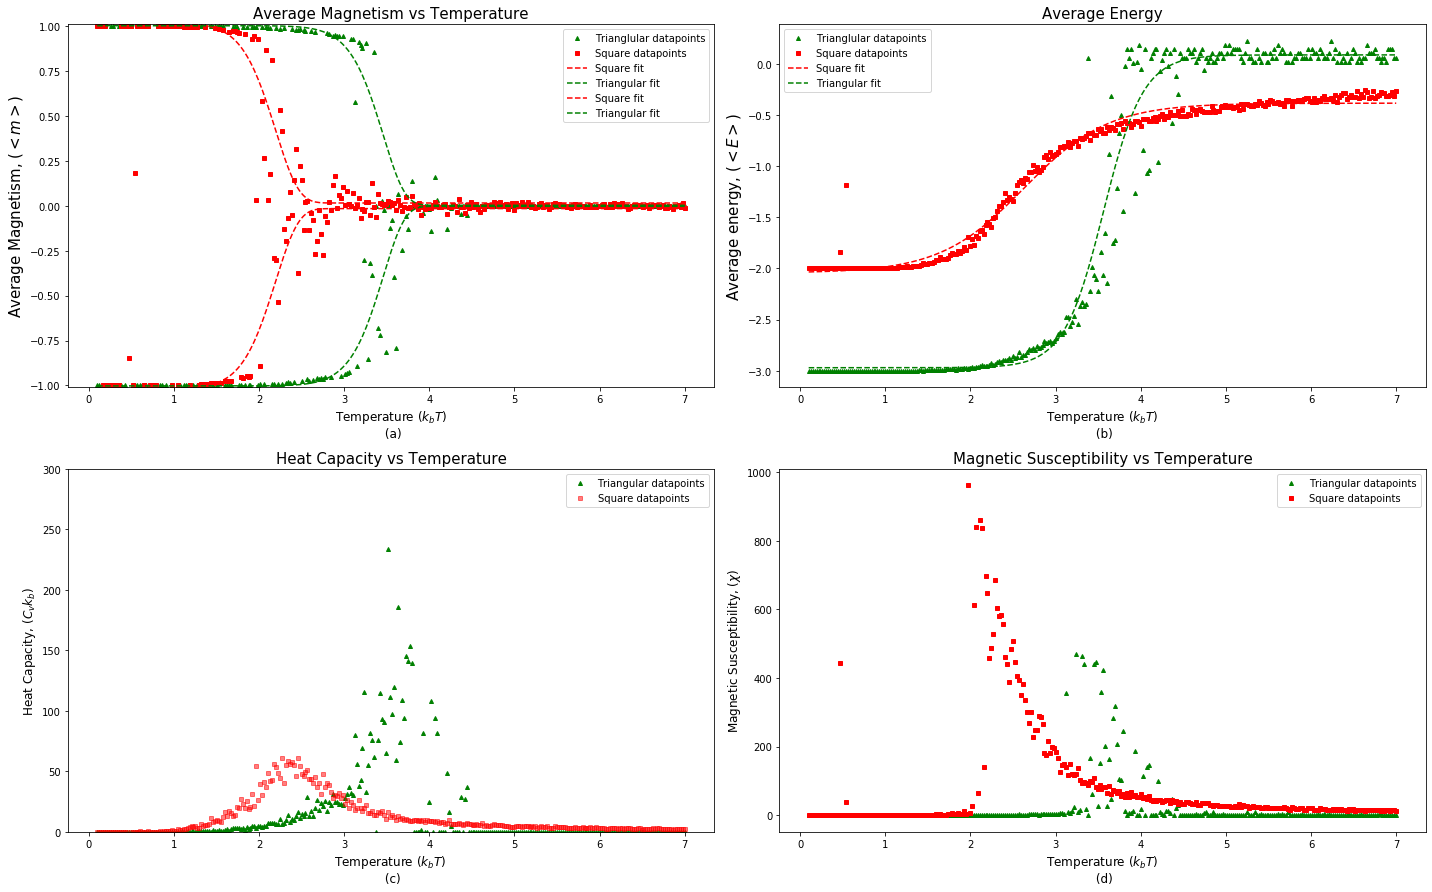

In [84]:
fig1 = plt.figure(figsize=(20,12.5))
ax1 = fig1.add_subplot(221)

ax1.plot(temp_list, avmag1,'g^',markersize = 4, label='Trianglular datapoints')
ax1.plot(temp_list, avmag, 'rs',markersize = 4, label='Square datapoints')

#fits
ax1.plot(temp_list, fit1,  'r--' ,label='Square fit' )
ax1.plot(temp_list, fit11, 'g--' ,label='Triangular fit' )
ax1.plot(temp_list, -fit1,  'r--' ,label='Square fit' )
ax1.plot(temp_list, -fit11, 'g--' ,label='Triangular fit' )
ax1.set_xlabel('Temperature ($k_b T$)\n (a)',fontsize=12)
ax1.set_ylabel('Average Magnetism, ($< m >$)',fontsize=15)
ax1.set_title('Average Magnetism vs Temperature',fontsize=15)
ax1.set_ylim(-1.01,1.01)
ax1.legend()

ax2 = fig1.add_subplot(222)

ax2.plot(temp_list, aven1, 'g^',markersize = 4, label='Trianglular datapoints')
ax2.plot(temp_list, (aven),'rs',markersize = 4, label='Square datapoints')

ax2.plot(temp_list, fit2, 'r--' ,label='Square fit' )
ax2.plot(temp_list, fit22, 'g--',label='Triangular fit' )
ax2.set_xlabel('Temperature ($k_b T$) \n (b)',fontsize=12)
ax2.set_ylabel('Average energy, ($< E >$)',fontsize=15)
ax2.set_title('Average Energy',fontsize=15)
ax2.legend()


ax3 = fig1.add_subplot(223)
ax3.set_ylim([0,300])
ax3.plot(temp_list, C1, 'g^',markersize = 4,label='Triangular datapoints')
ax3.plot(temp_list, C, 'rs',markersize = 4, alpha = 0.5,label='Square datapoints')
ax3.set_xlabel('Temperature ($k_b T$) \n (c)',fontsize=12)
ax3.set_ylabel('Heat Capacity, ($C_vk_b$)',fontsize=12)
ax3.set_title('Heat Capacity vs Temperature',fontsize=15)
ax3.legend()


ax4 = fig1.add_subplot(224)
ax4.plot(temp_list, X1, 'g^',markersize = 4,label='Triangular datapoints')
ax4.plot(temp_list, X, 'rs',markersize = 4,label='Square datapoints')
ax4.set_xlabel('Temperature ($k_b T$) \n (d)',fontsize=12)
ax4.set_ylabel('Magnetic Susceptibility, ($\chi$)',fontsize=12)
ax4.set_title('Magnetic Susceptibility vs Temperature',fontsize=15)
ax4.legend()

plt.tight_layout()
plt.show()

------------
# Investigating application of magnetic field over a of applied magnetic field for both lattice geometries
----------

In [85]:
m0, mf, magsteps = -4., 4., tempsteps
mag_list=np.linspace(m0,mf,magsteps)


In [86]:
avena=[]
avenat=[]

avmagat=[]
avmaga=[]

avenb=[]
avenbt=[]

avmagbt=[]
avmagb=[]

avenc=[]
avenct=[]

avmagc=[]
avmagct=[]

for i, mag in enumerate(mag_list):
    solvea=Solve(gridsize,  J=1. ,  T= 0.5, stopping_iter=testruns+countruns,field = mag,triangular=False) 
    solveat=Solve(gridsize,  J=1. ,  T= 1.5, stopping_iter=testruns+countruns,field = mag,triangular=True) 
    
    solveb=Solve(gridsize,  J=1. ,  T= 3., stopping_iter=testruns+countruns,field = mag,triangular=False) 
    solvebt=Solve(gridsize,  J=1. ,  T= 4., stopping_iter=testruns+countruns,field = mag,triangular=True)
    
    solvec=Solve(gridsize,  J=1. ,  T= 5., stopping_iter=testruns+countruns,field = mag,triangular=False) 
    solvect=Solve(gridsize,  J=1. ,  T= 6., stopping_iter=testruns+countruns,field = mag,triangular=True)

    solvea.isinginate()
    solveat.isinginate()
    
    solveb.isinginate()
    solvebt.isinginate()
    
    solvec.isinginate()
    solvect.isinginate()
    
    avmaga.append(np.mean(solvea.mag_list[-countruns:]))
    avena.append(np.mean(solvea.en_list[-countruns:]))
    avmagat.append(np.mean(solveat.mag_list[-countruns:]))
    avenat.append(np.mean(solveat.en_list[-countruns:]))
    
    avmagb.append(np.mean(solveb.mag_list[-countruns:]))
    avenb.append(np.mean(solveb.en_list[-countruns:]))
    avmagbt.append(np.mean(solvebt.mag_list[-countruns:]))
    avenbt.append(np.mean(solvebt.en_list[-countruns:]))
    
    avmagc.append(np.mean(solvec.mag_list[-countruns:]))
    avenc.append(np.mean(solvec.en_list[-countruns:]))
    avmagct.append(np.mean(solvect.mag_list[-countruns:]))
    avenct.append(np.mean(solvect.en_list[-countruns:]))    


avmaga =np.array(avmaga)/(gridsize**2)
avena=np.array(avena)/(gridsize**2)
avmagat= np.array( avmagat )/(gridsize**2)
avenat=np.array(avenat)/(gridsize**2)
               
avmagb =np.array(avmagb)/(gridsize**2)
avenb=np.array(avenb)/(gridsize**2)
avmagbt=np.array(avmagbt)/(gridsize**2)
avenbt=np.array(avenbt)/(gridsize**2)
               
avmagc =np.array(avmagc)/(gridsize**2)
avenc=np.array(avenc)/(gridsize**2)
avmagct=np.array(avmagct)/(gridsize**2)
avenct=np.array(avenct)/(gridsize**2)

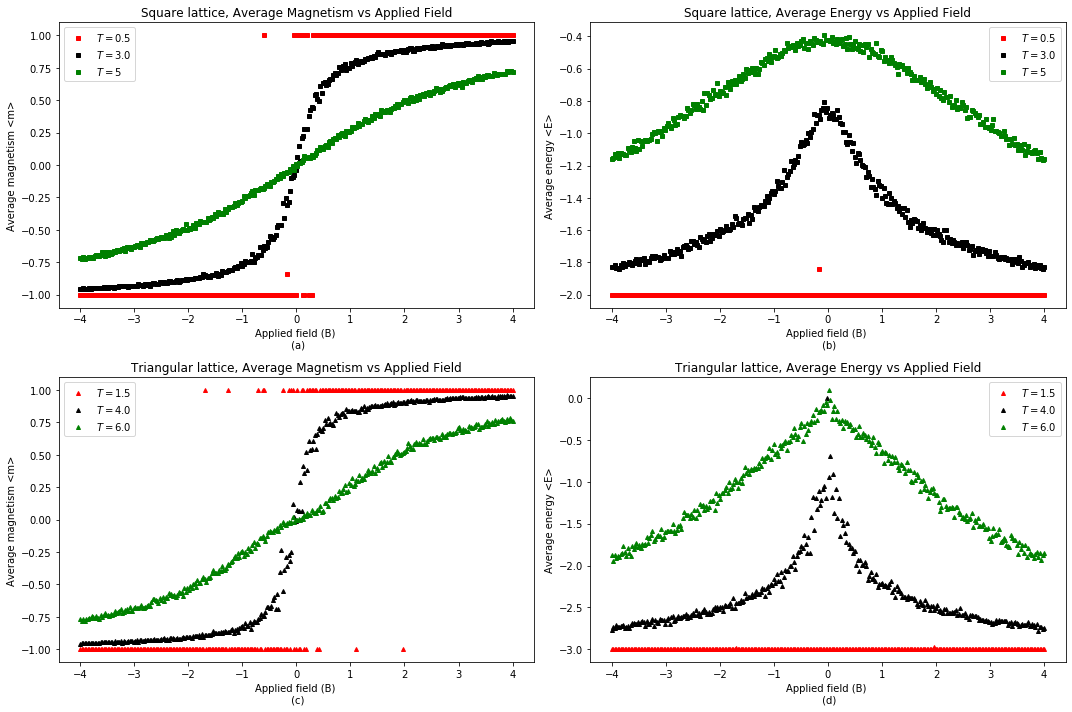

In [87]:
fig3 = plt.figure(figsize=(15,10))

ax111 = fig3.add_subplot(221)
ax111.plot(mag_list,avmaga, 'rs',markersize = 4, label='$T=0.5$')
ax111.plot(mag_list,avmagb, 'ks',markersize = 4, label='$T=3.0$')
ax111.plot(mag_list,avmagc, 'gs',markersize = 4, label='$T=5.$')
ax111.set_xlabel('Applied field (B) \n (a)')
ax111.set_ylabel('Average magnetism <m>')
ax111.set_title('Square lattice, Average Magnetism vs Applied Field')
ax111.legend()

ax222 = fig3.add_subplot(222)
ax222.plot(mag_list,avena, 'rs',markersize = 4, label='$T=0.5$')
ax222.plot(mag_list,avenb, 'ks',markersize = 4, label='$T=3.0$')
ax222.plot(mag_list,avenc, 'gs',markersize = 4, label='$T=5.$')
ax222.set_xlabel('Applied field (B) \n (b)')
ax222.set_ylabel('Average energy <E>')
ax222.set_title('Square lattice, Average Energy vs Applied Field')
ax222.legend()

ax333 = fig3.add_subplot(223)
ax333.plot(mag_list,avmagat, 'r^',markersize = 4, label='$T=1.5$')
ax333.plot(mag_list,avmagbt, 'k^',markersize = 4, label='$T=4.0$')
ax333.plot(mag_list,avmagct, 'g^',markersize = 4, label='$T=6.0$')
ax333.set_xlabel('Applied field (B) \n (c)')
ax333.set_ylabel('Average magnetism <m>')
ax333.set_title('Triangular lattice, Average Magnetism vs Applied Field')
ax333.legend()

ax444 = fig3.add_subplot(224)
ax444.plot(mag_list,avenat, 'r^',markersize = 4, label='$T=1.5$')
ax444.plot(mag_list,avenbt, 'k^',markersize = 4, label='$T=4.0$')
ax444.plot(mag_list,avenct, 'g^',markersize = 4, label='$T=6.0$')
ax444.set_xlabel('Applied field (B) \n (d)')
ax444.set_ylabel('Average energy <E>')
ax444.set_title('Triangular lattice, Average Energy vs Applied Field')
ax444.legend()

plt.tight_layout()
plt.show()

 ------------
# Animation
----------

In [146]:
#Set the geometry of the system
gridsize, stopping_iter =52, 30
triangular = True

#Set the thermodynamic parameters of the system
J ,T, B = 1.,5., 0.

test=Solve(gridsize, J ,  T, stopping_iter, field=B, triangular = triangular)
test.isinginate()
states_list=test.states


<IPython.core.display.Javascript object>


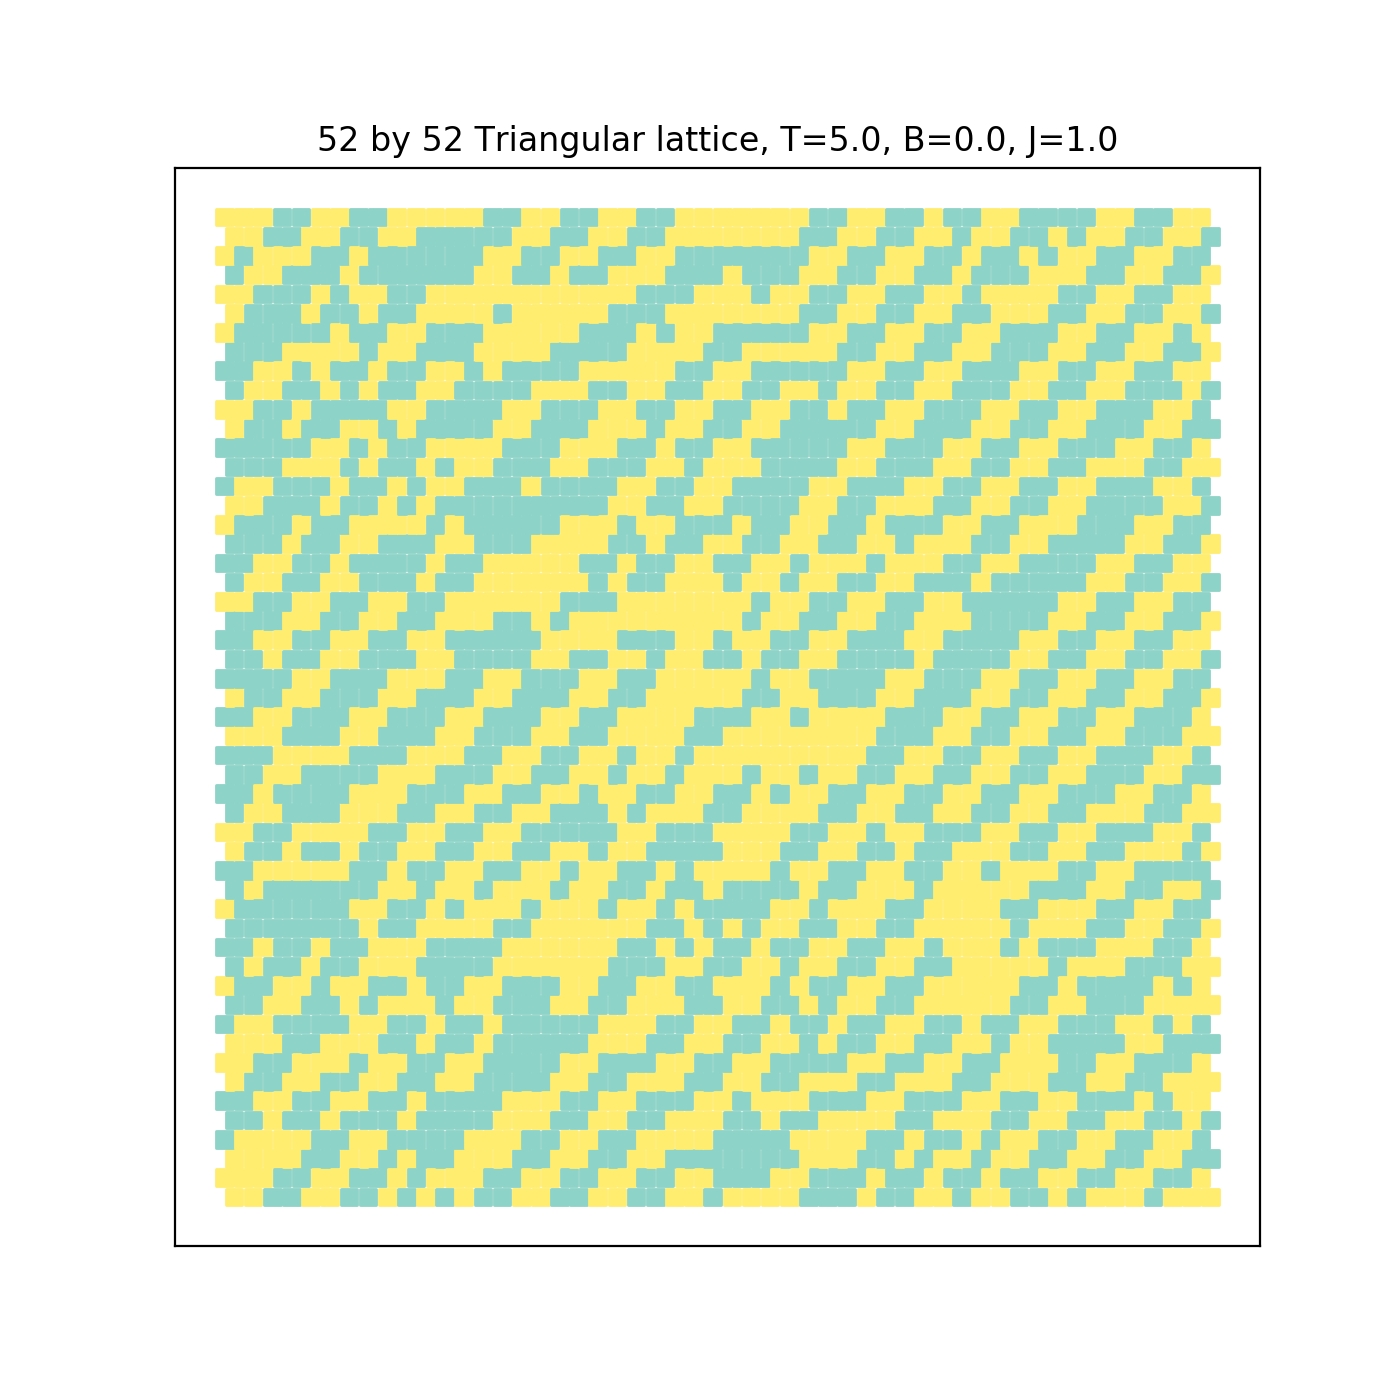

In [148]:
import scipy as sp
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib notebook

if triangular==True:
    
    statesT_list=[]
    for i in range(0,len(states_list)):
        statesT_list.append(states_list[i].flatten())

    points=np.array([[a-(b%2)*(0.5), b*np.sqrt(3)/2] for a in np.linspace(0,gridsize-1,gridsize) for b in np.linspace(0,gridsize-1,gridsize)])
    num_el=gridsize**2
    H = statesT_list[0]

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    im = ax.scatter(points[:,0],points[:,1], marker='s', c=H, vmin=-1, vmax=1,cmap=cm.Set3)
    im.set_array( sp.zeros(H.shape) )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%d by %d Triangular lattice, T=%s, B=%s, J=%s'%(gridsize,gridsize,T,B,J))

    def update_data(n):
        H = statesT_list[n]  # More random data
        im.set_array(H)
        return

    ani = animation.FuncAnimation(fig, update_data,stopping_iter, repeat = False)
    fig.show()
    
else:
    num_el=gridsize**2
    H = states_list[0] # initalize with random data

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    im = ax.matshow(H, vmin=-1, vmax=1,cmap=cm.Set3)
    im.set_data( sp.zeros(H.shape) )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%d by %d Square lattice, T=%s, B=%s, J=%s'%(gridsize,gridsize,T,B,J))

    def update_data(n):
        H = states_list[n]  # More random data
        im.set_data(H)
        return

    ani = animation.FuncAnimation(fig, update_data, stopping_iter, repeat = False)

    fig.show()

In [85]:
#Saving as a gif file
#SAVE WHEN YOUR IN REGULAR PYTHON NOTEBOOK MODE NOT MATPLOTLIB

file='tri'+'T'+str((T))+'gs'+str(gridsize)+'J'+str(J)+'B'+str(B)+'.gif'
ani.save(file, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.
